## **IMPORT**

In [1]:
from ChessCore import *

## **TESTS**

### TEST FUNCTION

*Input:*
- `fen`: FEN string representing the current state of the game
- `king_moves_only`: Whether you want to see all possible moves or only the king's moves (Optional)

*Output:* Plot the board and all querried moves

In [2]:
def chess_move_generation_test(fen: str = None, king_moves_only: bool = False):
    game = ChessGame() if fen is None else ChessGame(fen)
    moves = game.generate_all_moves()
    if king_moves_only:
        king_position = game.get_king_position(game.side_to_move())
        if king_position >= 0:
            moves = [move for move in moves if move.start_position() == king_position]
    game.plot(moves=moves)

### TEST 1

- Default pieces placement
- White moves
- Castling rights:
    - White: king's side, queen's side
    - Black: king's side, queen's side

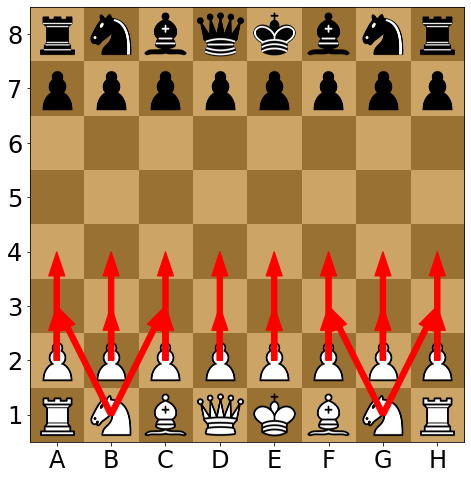

In [3]:
chess_move_generation_test()

### TEST 2

- White king and rooks didn't moved, black king moved
- White moves
- Castling rights:
    - White: king's side, queen's side
    - Black: none

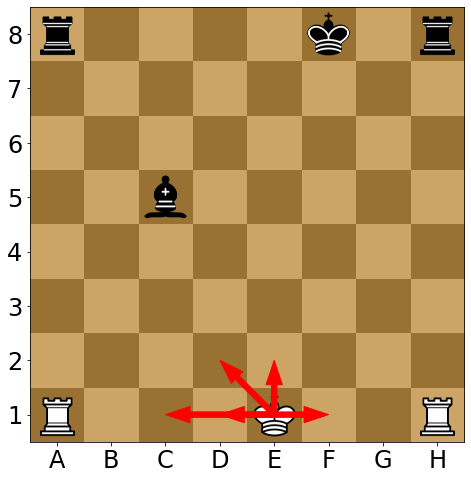

In [4]:
chess_move_generation_test('r4k1r/8/8/2b5/8/8/8/R3K2R w KQ - 0 42', king_moves_only=True)

### TEST 3

- Black knight at 

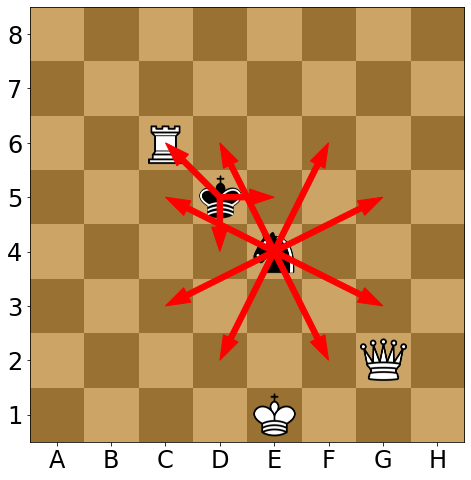

In [6]:
chess_move_generation_test('8/8/2R5/3k4/4n3/8/6Q1/4K3 b - - 0 241')